In [5]:
import torch, math
import torch.nn as nn
import torch.nn.functional as F


def second_order_polynomial(x_q, s_x, a, b, c):
    """a(x+b)^2 + c"""
    """Kim, Sehoon, et al. "I-bert: Integer-only bert quantization." International conference on machine learning. PMLR, 2021."""
    with torch.no_grad():
        # [ Can be pre-computed ]
        q_b = torch.floor(b / s_x)  # PRE-COMPUTED >> INT
        q_c = torch.floor(c / (a * s_x**2))  # PRE-COMPUTED >> INT
        s_out = a * s_x**2  # PRE-COMPUTED-FP

    q_out = (x_q + q_b).pow(2) + q_c

    return q_out, s_out


def int_ERF(x_q, s_x):
    with torch.no_grad():
        a, b, c = -0.2888, -1.769, 1
        a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)

    """ONLY INT OPERATION"""
    _q = torch.min(x_q.abs(), (-b / s_x))

    q_L, s_L = second_order_polynomial(_q, s_x, a, b, c)

    q_out = torch.sign(x_q) * q_L

    return q_out, s_L


def int_GELU(x_q, s_x):
    with torch.device(x_q.device):
        # input : (INT, PRE-COMPUTED-FP)
        q_erf, s_erf = int_ERF(x_q, s_x / math.sqrt(2))
        # output : (INT, PRE-COMPUTED-FP)

        q_1 = torch.floor(1 / s_erf)  # floor(1 / PRE-COMPUTED-FP) >> INT

        q_out = x_q * (q_erf + q_1)  # INT
        s_out = s_x * s_erf / 2  # PRE-COMPUTED-FP

        return q_out, s_out




In [6]:
# def int_EXP(x_q, s_x):
#     with torch.no_grad():
#         a, b, c = 0.3585, 1.353, 0.344
#         a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)

#         q_ln2 = torch.floor(math.log(2) / s_x)  # PRE-COMPUTED >> INT

#     """ONLY INT OPERATION"""
#     z = torch.floor(-x_q / q_ln2)  # INT

#     q_p = x_q + z * q_ln2  # INT

#     q_L, s_L = second_order_polynomial(q_p, s_x, a, b, c)

#     q_out = q_L / 2**z

#     return q_out, s_L


# def int_Softmax(x_q, s_x):
#     q_hat = x_q - x_q.max(dim=-1).values.unsqueeze(-1)
#     q_exp, s_exp = int_EXP(q_hat, s_x)
#     q_out = q_exp / q_exp.sum(dim=-1).unsqueeze(-1)
#     return q_out, s_exp

z min : 0.0, z max : 14.0
p min : -0.5610063076019287, p max : 0.0
tensor(2.7389)


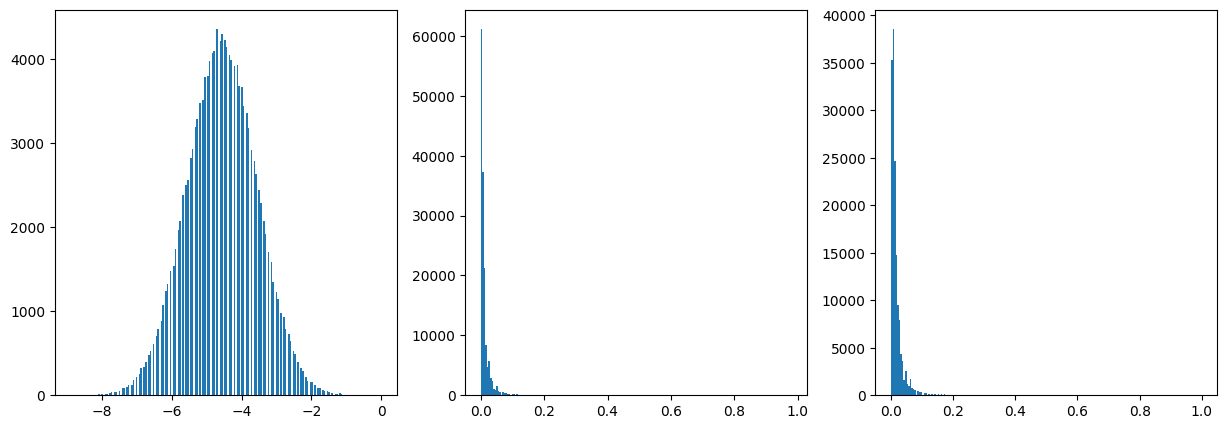

In [7]:
torch.random.manual_seed(0)

import matplotlib.pyplot as plt

def int_EXP(x_q, s_x):
    a, b, c = 0.3585, 1.353, 0.344
    a, b, c = torch.tensor(a), torch.tensor(b), torch.tensor(c)

    q_ln2 = torch.floor(0.693147 / s_x)
    z = torch.floor(-x_q / q_ln2)
    print(f"z min : {z.min()}, z max : {z.max()}")
    q_p = x_q + z * q_ln2
    p = q_p*s_x
    print(f"p min : {p.min()}, p max : {p.max()}")
    q_L, s_L = second_order_polynomial(q_p, s_x, a, b, c)

    q_out = torch.bitwise_right_shift(q_L.to(torch.int32), z.to(torch.int32)).to(torch.float32)
    # q_out = (q_L / 2**z).round()
    s_out = s_L

    return q_out, s_out

x = torch.randn((1, 197, 768))
x = x - x.abs().max()
s = x.abs().max() / 127

x_q = torch.clip((x / s).round(), -128, 127)  # quant
x_fp = x_q * s  # dequant



expx1_q, s1 = int_EXP(x_q, s)
expx1_fp = expx1_q * s1
# print(expx1)

orgexp = torch.exp(x_fp)
# print(orgexp)

print(torch.norm(orgexp - expx1_fp))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(x_fp.flatten().numpy(), bins=200)
ax[1].hist(expx1_fp.flatten().numpy(), bins=200)
ax[2].hist(orgexp.flatten().numpy(), bins=200)
plt.show()

123
z min : -0.0, z max : 12.0
p min : -0.5688172578811646, p max : 0.0
len ex1 10416
tensor(0.0018)
expp1 : 0.0, 0.0933152362704277 , sum : 197.00001525878906
org : 8.597779014962725e-06, 0.06856003403663635 , sum : 196.99998474121094
tensor(0.1139)


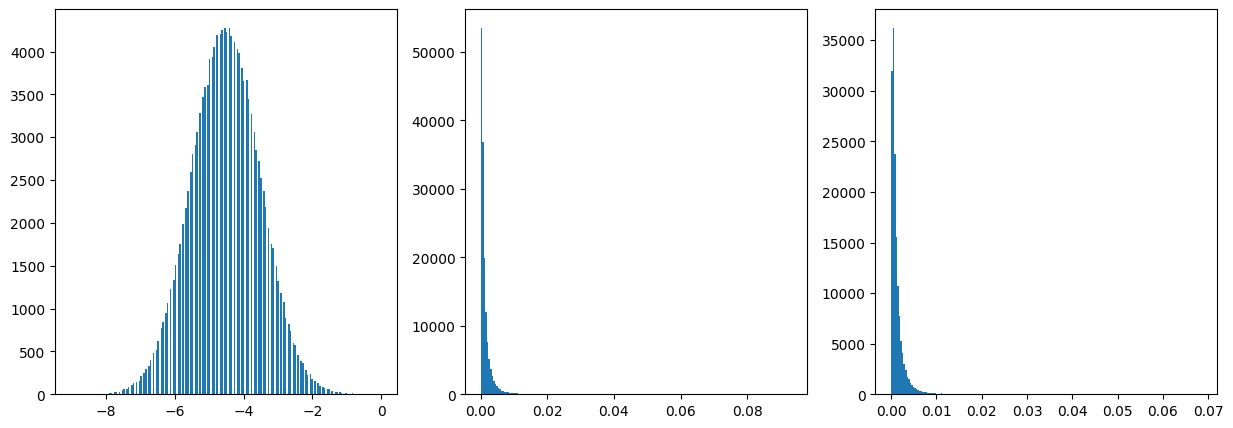

In [16]:
def int_Softmax(x_q, s_x):
    q_hat = x_q - x_q.max(dim=-1).values.unsqueeze(-1)
    q_exp, s_exp = int_EXP(q_hat, s_x)
    q_out = q_exp / q_exp.sum(dim=-1).unsqueeze(-1)
    return q_out, s_exp


x = torch.randn((1, 197, 768))
x = x - x.abs().max()
s = x.abs().max() / 127

x_q = torch.clip((x / s).round(), -128, 127)  # quant
x_fp = x_q * s  # dequant
print(len(set(x_q.flatten().numpy())))
expx1_q, s1 = int_Softmax(x_q, s)
expx1_fp = expx1_q # s1





print(s1)
print(f"expp1 : {expx1_fp.min()}, {expx1_fp.max()} , sum : {expx1_fp.sum()}")


orgexp = torch.softmax(x_fp, dim=-1)
# print(orgexp)

print(f"org : {orgexp.min()}, {orgexp.max()} , sum : {orgexp.sum()}")

print(torch.norm(orgexp - expx1_fp))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(x_fp.flatten().numpy(), bins=200)
ax[1].hist(expx1_fp.flatten().numpy(), bins=200)
ax[2].hist(orgexp.flatten().numpy(), bins=200)
plt.show()

In [ ]:
"""

softmax 최종 결과가 8비트이지 않은 것 같음. 수정 필요함

"""

113
z min : 0.0, z max : 11.0
p min : -0.6082737445831299, p max : 0.0
128
expp1 : 0.0, 0.06611329317092896 , sum : 196.90846252441406
org : 6.406338343367679e-06, 0.06037862226366997 , sum : 197.00003051757812
tensor(0.0405)


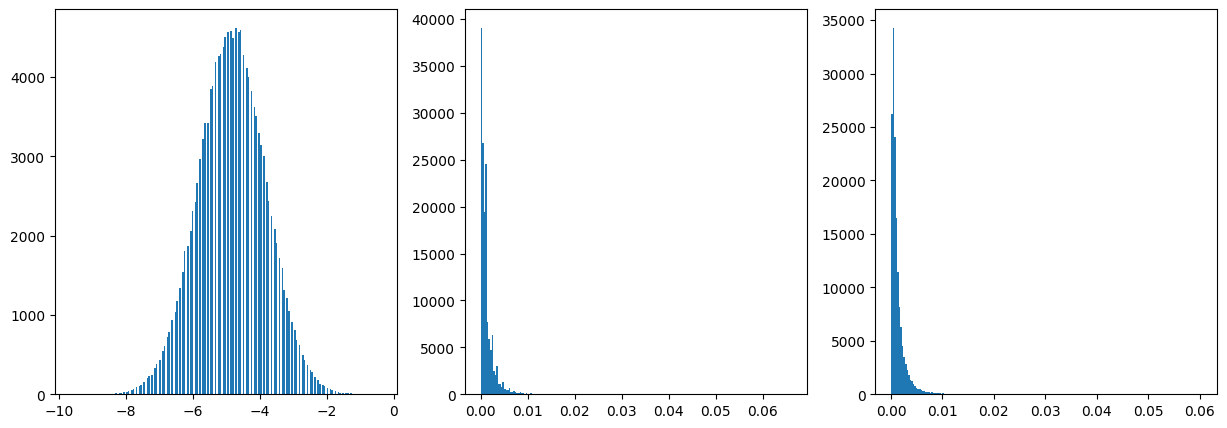

In [19]:
def int_Softmax(x_q, s_x):
    q_hat = x_q - x_q.max(dim=-1).values.unsqueeze(-1)
    q_exp, s_exp = int_EXP(q_hat, s_x)
    q_out = q_exp / q_exp.sum(dim=-1).unsqueeze(-1)
    return q_out, s_exp


x = torch.randn((1, 197, 768))
x = x - x.abs().max()
s = x.abs().max() / 127

x_q = torch.clip((x / s).round(), -128, 127)  # quant
x_fp = x_q * s  # dequant
print(len(set(x_q.flatten().numpy())))
expx1_q, s1 = int_Softmax(x_q, s)

s = expx1_q.abs().max() / 255
expx1_q = torch.clip((expx1_q / s).round(), 0, 255)  # quant
expx1_fp = expx1_q * s  # dequant
print(len(set(expx1_fp.flatten().numpy())))
print(f"expp1 : {expx1_fp.min()}, {expx1_fp.max()} , sum : {expx1_fp.sum()}")


orgexp = torch.softmax(x_fp, dim=-1)
# print(orgexp)

print(f"org : {orgexp.min()}, {orgexp.max()} , sum : {orgexp.sum()}")

print(torch.norm(orgexp - expx1_fp))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(x_fp.flatten().numpy(), bins=200)
ax[1].hist(expx1_fp.flatten().numpy(), bins=200)
ax[2].hist(orgexp.flatten().numpy(), bins=200)
plt.show()